# Predicción de cancelación de reservas hoteleras

1. Importar librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
sns.set(style="whitegrid")

2. Cargar datos

In [2]:
# Cargar datos
df = pd.read_csv('hotel_reservas_knn.csv')
df.head()

,dias_anticipacion,noches_estancia,precio_noche,num_huespedes,historico_cancelaciones,CANCELA
0,102,12,147.884114,2,1,0
1,348,6,167.298153,2,0,1
2,270,12,143.380129,3,1,1
3,106,11,137.986236,4,0,0
4,71,13,89.317820,4,2,1


3. EDA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   dias_anticipacion        2000 non-null   int64  
 1   noches_estancia          2000 non-null   int64  
 2   precio_noche             2000 non-null   float64
 3   num_huespedes            2000 non-null   int64  
 4   historico_cancelaciones  2000 non-null   int64  
 5   CANCELA                  2000 non-null   int64  
dtypes: float64(1), int64(5)
memory usage: 93.9 KB
Distribución CANCELA:
CANCELA
0    1341
1     659
Name: count, dtype: int64


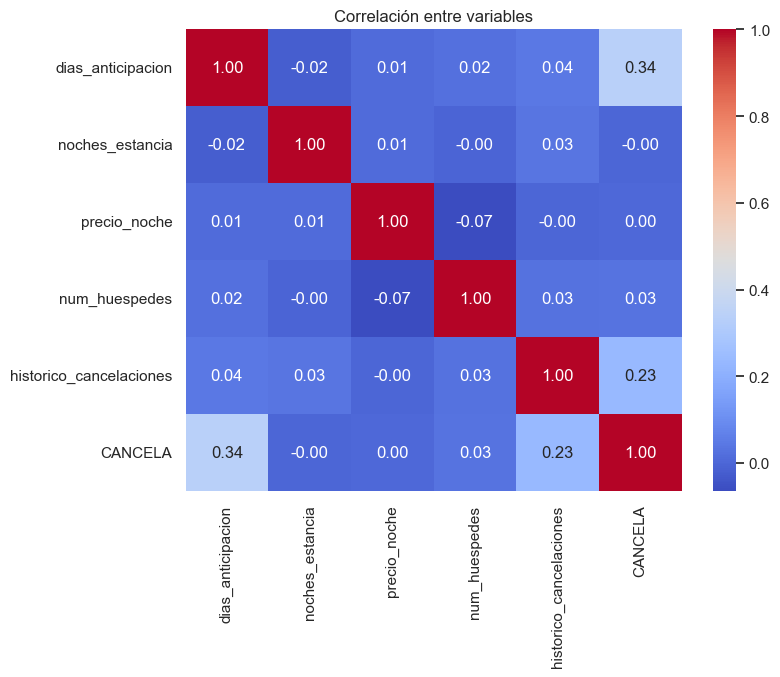

In [3]:
# EDA: información básica y distribución de la variable objetivo
df.info()
df.describe().T

# Comprobar valores nulos
df.isnull().sum()

# Distribución de la variable objetivo
print('Distribución CANCELA:')
print(df['CANCELA'].value_counts())

# Matriz de correlación
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlación entre variables')
plt.show()

4. Escalar variables

In [4]:
# Escalar variables numéricas
X = df.drop('CANCELA', axis=1)
y = df['CANCELA']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled.head()

,dias_anticipacion,noches_estancia,precio_noche,num_huespedes,historico_cancelaciones
0,-0.756213,1.133784,0.729689,-0.415358,0.047390
1,1.562114,-0.349903,1.233251,-0.415358,-1.029646
2,0.827035,1.133784,0.612865,0.484660,0.047390
3,-0.718516,0.886503,0.472958,1.384678,-1.029646
4,-1.048360,1.381065,-0.789406,1.384678,1.124426


5. Train/Test split

In [5]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
print('Tamaños: ', X_train.shape, X_test.shape)

Tamaños:  (1400, 5) (600, 5)


6. Modelo KNN inicial

In [6]:
# Modelo KNN inicial (k=5)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

7. Evaluación

Accuracy: 0.6867


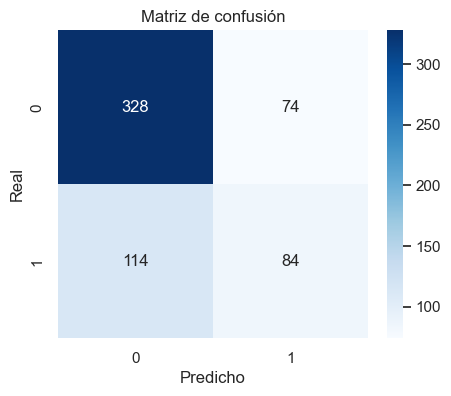

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.74      0.82      0.78       402
           1       0.53      0.42      0.47       198

    accuracy                           0.69       600
   macro avg       0.64      0.62      0.62       600
weighted avg       0.67      0.69      0.68       600

ROC AUC: 0.7074


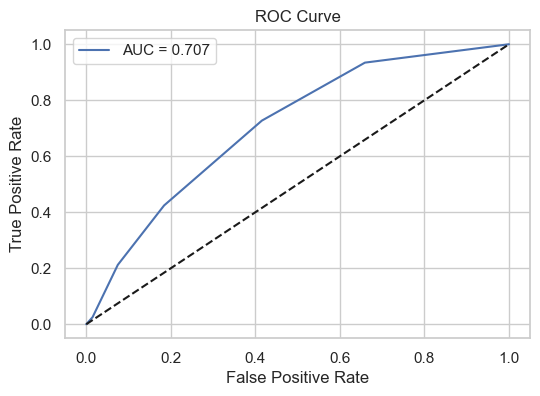

In [7]:
# Evaluación
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {acc:.4f}')

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de confusión')
plt.show()

print('Reporte de clasificación:')
print(classification_report(y_test, y_pred))

# ROC AUC
if len(np.unique(y_test)) == 2:
    y_proba = knn.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_proba)
    print(f'ROC AUC: {auc:.4f}')
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

8. Método del codo (error rate)

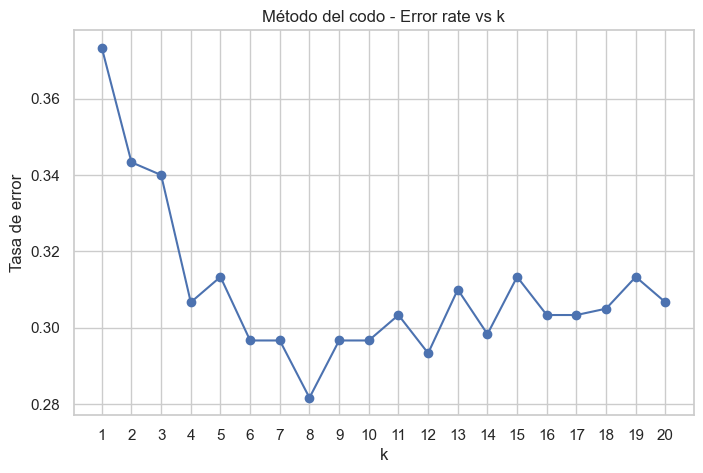

In [8]:
# Método del codo: tasa de error para distintos valores de k
error_rate = []
ks = range(1,21)
for k in ks:
    knn_k = KNeighborsClassifier(n_neighbors=k)
    knn_k.fit(X_train, y_train)
    pred_k = knn_k.predict(X_test)
    error = np.mean(pred_k != y_test)
    error_rate.append(error)

plt.figure(figsize=(8,5))
plt.plot(ks, error_rate, marker='o')
plt.xlabel('k')
plt.ylabel('Tasa de error')
plt.title('Método del codo - Error rate vs k')
plt.xticks(ks)
plt.grid(True)
plt.show()